In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# miscellaneous
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# deep learning stack
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image

#### Load pretrained model

In [2]:
# use mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [3]:
import os
CLASSES = os.listdir('./data/Trainimages')
CLASSES

['Shoes', 'Spoons', 'Books', 'Forks']

In [4]:
# define an image data generator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
data_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
# a generator that returns batches of x and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory='./data/Trainimages/',
        class_mode="categorical",
        classes=CLASSES,
        batch_size=300,
        target_size=(224, 224)
)

Found 400 images belonging to 4 classes.


In [6]:
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((300, 224, 224, 3), (300, 4))

In [7]:
BASE_MODEL = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,          # controls number of overall weights
    include_top=False,  # removal of final dense layers
    pooling='avg',      # global average pooling applied to last convolutional layer's ouput
    input_shape=(224,224,3)
)

# freeze it!
BASE_MODEL.trainable = False

In [8]:
model = keras.Sequential()

In [9]:
model.add(BASE_MODEL)

In [10]:
model.add(keras.layers.Dense(units=1280,activation='relu'))

model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(len(CLASSES), activation='softmax'))



In [11]:
from tensorflow.keras.optimizers import Adam as Eva

In [12]:
model.compile(optimizer=Eva(),
        loss=keras.losses.categorical_crossentropy,
        metrics=[tf.keras.metrics.categorical_accuracy])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1280)              1639680   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 3,902,788
Trainable params: 1,644,804
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=3, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'  
    #Exercise! More things to look up in the documentation:
    #restore_best_weights
    #baseline
)

In [15]:

hist = model.fit(xtrain, ytrain,
                 epochs=100, # 1 epoch is 1 iteration over entire X and y data
                 batch_size=10, # number of samples per gradient update
                 validation_split=0.2,
                 callbacks = [early_stop]
                )

Epoch 1/100
24/24 [==============================] - 10s 326ms/step - loss: 1.0628 - categorical_accuracy: 0.7000 - val_loss: 0.1808 - val_categorical_accuracy: 0.9167
Epoch 2/100
24/24 [==============================] - 7s 293ms/step - loss: 0.1375 - categorical_accuracy: 0.9500 - val_loss: 0.2252 - val_categorical_accuracy: 0.9000
Epoch 3/100
24/24 [==============================] - 8s 353ms/step - loss: 0.1405 - categorical_accuracy: 0.9417 - val_loss: 0.1152 - val_categorical_accuracy: 0.9333
Epoch 4/100
24/24 [==============================] - 7s 295ms/step - loss: 0.0805 - categorical_accuracy: 0.9708 - val_loss: 0.0993 - val_categorical_accuracy: 0.9833
Epoch 5/100
24/24 [==============================] - 7s 299ms/step - loss: 0.0700 - categorical_accuracy: 0.9833 - val_loss: 0.1134 - val_categorical_accuracy: 0.9500
Epoch 6/100
24/24 [==============================] - 7s 298ms/step - loss: 0.0605 - categorical_accuracy: 0.9875 - val_loss: 0.0620 - val_categorical_accuracy: 0.98

In [16]:
# losses in the training history
losses = pd.DataFrame(model.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

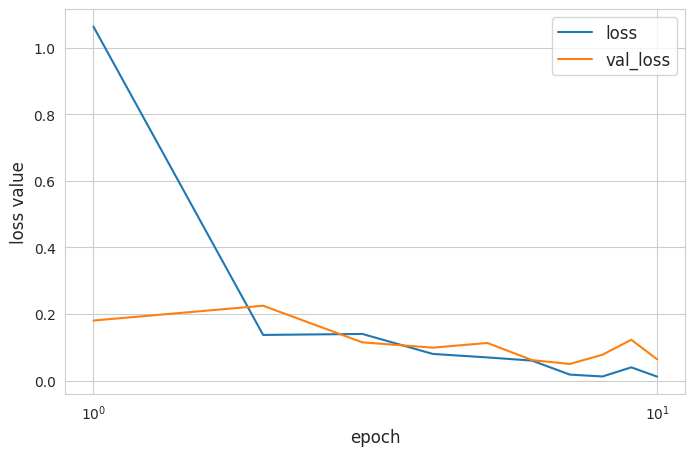

In [17]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,5),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=12)
plt.ylabel('loss value',fontsize=12)
plt.legend(loc=1,fontsize=12);

In [18]:
def image_predict(preprocessed_image, model):
    """
    This function returns class probabilities for a given image,
    based on the model obtained via transfer learning 
    """
    probabilities = model.predict(
        preprocessed_image,
        verbose=0
    )
    probabilities = np.round(probabilities,6)[0].tolist()
    class_probabilities = {
        k:v for (k,v) in zip(CLASSES,probabilities)
    }
    return class_probabilities

In [19]:
# a generator that returns batches of X and y arrays
test_data_gen = data_gen.flow_from_directory(
        directory='./data/Testimages/',
        class_mode="categorical",
        classes=CLASSES,
        target_size=(224, 224)
)

Found 39 images belonging to 4 classes.


In [20]:
# load in all images at once
xtest, ytest = next(test_data_gen)
xtest.shape, ytest.shape

((32, 224, 224, 3), (32, 4))

In [21]:
def transfer_learning_prediction(model,x,y):
    """
    This function returns a dataframe with class probabilities
    along with true class label 
    """
    # convert vectorized classes into strings
    y = [''.join([i*j for (i,j) in zip(CLASSES,vector)]) for vector in y.astype(int)]
    # prediction dataframe along with true class
    prediction_df = pd.DataFrame(
        columns=CLASSES,
        data=np.round(model.predict(x,verbose=0),3)
    )
    prediction_df['class'] = y
    return prediction_df

In [22]:
transfer_learning_prediction(
    model,xtrain,ytrain
)

,Shoes,Spoons,Books,Forks,class
0,0.999,0.001,0.0,0.001,Shoes
1,0.998,0.002,0.0,0.001,Shoes
2,1.000,0.000,0.0,0.000,Shoes
3,0.000,0.000,0.0,1.000,Forks
4,1.000,0.000,0.0,0.000,Shoes
...,...,...,...,...,...
295,1.000,0.000,0.0,0.000,Shoes
296,0.000,1.000,0.0,0.000,Spoons
297,0.000,0.002,0.0,0.998,Forks
298,1.000,0.000,0.0,0.000,Shoes


In [23]:
transfer_learning_prediction(
    model,xtest,ytest
)

,Shoes,Spoons,Books,Forks,class
0,0.000,1.000,0.000,0.000,Spoons
1,0.000,0.000,0.000,1.000,Forks
2,0.000,0.997,0.000,0.003,Spoons
3,1.000,0.000,0.000,0.000,Shoes
4,1.000,0.000,0.000,0.000,Shoes
5,0.997,0.003,0.000,0.000,Shoes
6,0.000,0.000,1.000,0.000,Books
7,0.000,0.600,0.000,0.400,Forks
8,0.000,1.000,0.000,0.000,Spoons
9,0.000,0.070,0.000,0.930,Forks


In [24]:
model.predict(np.array([xtest[26,:,:,:],]))

1/1 [==============================] - 0s 48ms/step


array([[1.2201919e-10, 9.9998903e-01, 1.2205493e-08, 1.0910879e-05]],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


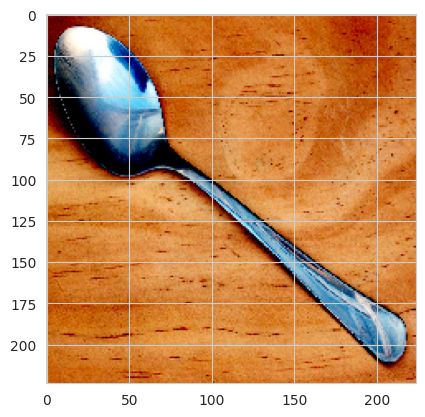

In [25]:
plt.imshow(xtest[26])

In [121]:
df=transfer_learning_prediction(
    model,xtest,ytest
)

In [123]:
cats=list(df.columns[0:4])
cnt=0
cnt2=0
for i,cat in enumerate(cats):
    cnt +=np.sum((np.argmax(np.array(df[df["class"]==cat].iloc[:,0:4]), axis=1)!=i)*1)
    cnt2+= len(df[df["class"]==cat])
    
print("accuracy:", 1-cnt/cnt2)

accuracy: 0.875


In [109]:
df[df["class"]=="Forks"]

,Shoes,Spoons,Books,Forks,class
1,0.0,0.000,0.0,1.000,Forks
7,0.0,0.600,0.0,0.400,Forks
9,0.0,0.070,0.0,0.930,Forks
11,0.0,0.000,0.0,1.000,Forks
17,0.0,0.001,0.0,0.999,Forks
18,0.0,0.000,0.0,1.000,Forks
24,0.0,0.000,0.0,1.000,Forks
28,0.0,0.499,0.0,0.501,Forks
30,0.0,0.000,0.0,1.000,Forks


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


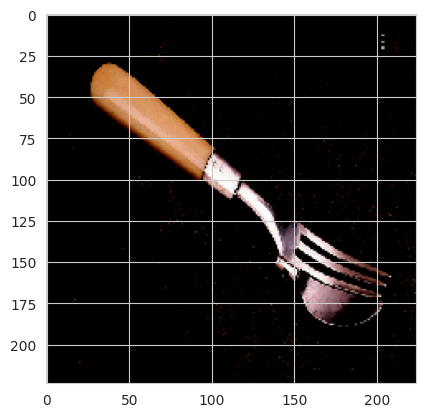

In [31]:
plt.imshow(xtest[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


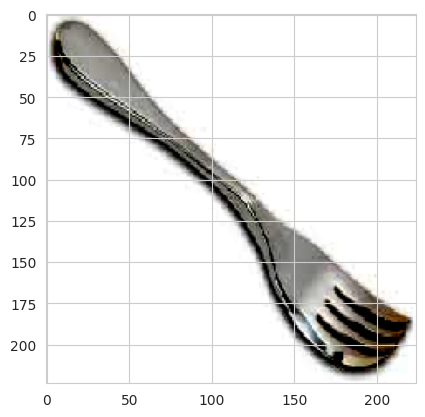

In [32]:
plt.imshow(xtest[28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


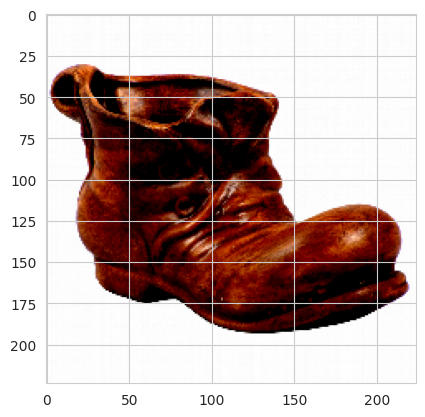

In [35]:
plt.imshow(xtest[31])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


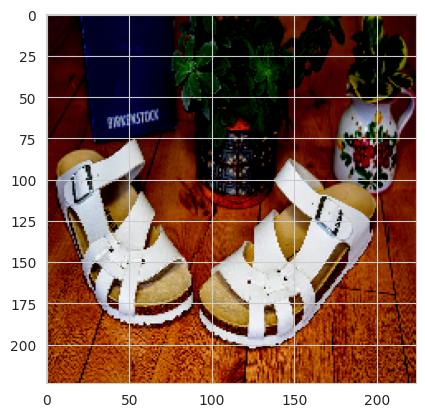

In [36]:
plt.imshow(xtest[14])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


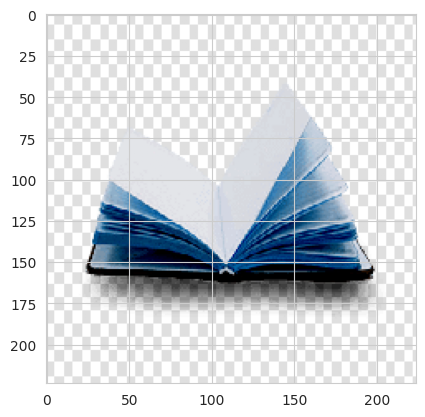

In [38]:
plt.imshow(xtest[25])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


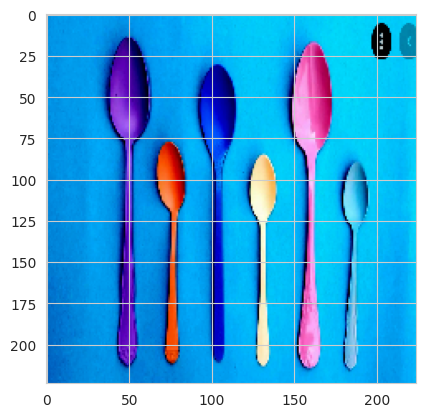

In [124]:
plt.imshow(xtest[10])

In [125]:
model.save("my_model.h5")

In [126]:
!ls

data  image_classifier.ipynb  my_model.h5  pics


In [128]:
xtest.shape

(32, 224, 224, 3)

In [132]:
(xtest[0]).shape

(224, 224, 3)